# Install Required Libraries

In [ ]:
!pip install -U alive_progress
!pip install geomloss[full]

In [ ]:
import torch

In [ ]:
import re
import sys
import random
import pickle
import IPython
import itertools
import warnings
from sklearn import preprocessing

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import linear_model
from geomloss import SamplesLoss
from alive_progress import alive_bar
# from scipy.stats import energy_distance
from sklearn.metrics import mean_squared_error

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [ ]:
warnings.filterwarnings(action='once')

In [ ]:
init_seed = 1640

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sys.path.append(f'/content/drive/MyDrive/joint_level_generation_translation/')

In [ ]:
!ls

drive  sample_data


In [ ]:
%cd drive/MyDrive/joint_level_generation_translation/double_check/generations/{init_seed}

/content/drive/MyDrive/joint_level_generation_translation/double_check/generations/1640


In [ ]:
!pwd

/content/drive/MyDrive/joint_level_generation_translation/double_check/generations/1640


# Evaluation Metrics
Inspired from https://github.com/riffsircar/Zelda-Metroid-CVAE/

### Leniency

In [ ]:
def leniency(frame):
    total = 0
    for l in frame:
        total += len(l)-l.count('H') -0.5 * l.count('M')
    return total

In [ ]:
def linearity(frame):
    # creating a dataframe to save all the detected platforms
    frame_platforms = pd.DataFrame(columns=['string','start_x','start_y','end_x','end_y'])

    # convert the platforms that can potentially represent a platform to single character
    # we do this step to make it easier to use regular expression.
    platform_chars = ['M', 'T', '#', "S", "B"]
    for w in range(len(frame)):
        for h in range(len(frame[0])):
            if frame[w][h] in platform_chars:
                frame[w][h] = '#'

    # define a regex to detect platforms
    p = re.compile('#*')
    for y in range(len(frame)):
        row_y = "".join(q for q in frame[y])
        for m in p.finditer(row_y):
            # why can't a platform length be 1?
            if len(m.group())>1:
                test = {
                    'string':m.group(),
                    'start_x':m.start(),
                    'start_y':y,
                    'end_x':m.end(),
                    'end_y':y,
                }
                # frame_platforms = pd.concat([frame_platforms, {
                #     'string':m.group(),
                #     'start_x':m.start(),
                #     'start_y':y,
                #     'end_x':m.end(),
                #     'end_y':y,
                # }], ignore_index=True)
                frame_platforms = pd.concat([frame_platforms, pd.DataFrame([test])], ignore_index=True)
                # frame_platforms=frame_platforms.append({
                #     'string':m.group(),
                #     'start_x':m.start(),
                #     'start_y':y,
                #     'end_x':m.end(),
                #     'end_y':y,
                # },ignore_index=True)

    if len(frame_platforms)>0:
        frame_platforms['center_x'] = np.ceil((frame_platforms['end_x']+frame_platforms['start_x'])/2)
        frame_platforms['center_y'] = frame_platforms['start_y']
        x = np.array(frame_platforms.center_x)
        y = np.array(frame_platforms.center_y)

        # set one linear reg model for each frame that detects  platforms
        new_model = linear_model.LinearRegression().fit(x.reshape((-1, 1)), y.reshape((-1, 1)))
        y_pred = new_model.predict(x.reshape(-1, 1))
        y_pred = [x[0] for x in y_pred]

        # calculate the linearity score
        score = mean_squared_error(y,y_pred)
        return score

In [ ]:
def interestingness(frame):
    total = 0
    for l in frame:
        total += l.count('H') + l.count('M') + l.count('D') + l.count('O')
    return total

In [ ]:
def nonlinearity(segment,game='smb'):
    if game != 'ki':
        level = [[segment[j][i] for j in range(len(segment))] for i in range(len(segment[0]))]
    else:
        level = segment
    x = np.arange(16)
    y = []
    for i, lev in enumerate(level):
        appended = False
        for j, l in enumerate(lev):
            if l != '-' and l != 'P':
                y.append(len(l)-j)
                appended = True
                break
        if not appended:
            y.append(0)
    x = x.reshape(-1,1)
    y = np.asarray(y)
    reg = linear_model.LinearRegression()
    reg.fit(x,y)
    y_pred = reg.predict(x)
    mse = mean_squared_error(y,y_pred)
    return (int(round(mse)))

In [ ]:
def convert_to_list(list_of_numpy: list) -> "list[list[str]]":
  result = []
  for line in list_of_numpy:
    result.append(line.tolist())
  return result

In [ ]:
def calc_and_store_eval_metrics(filename, mode="entire"):
  with open(f"{filename}.pkl", "rb") as fh:
      data = pickle.load(fh)
      # if len(data) >= 360:
      #   data = random.sample(data, 360)
      to_write = []
      with alive_bar(len(data), force_tty=True) as bar:
        for frame in data:
            frame = convert_to_list(frame)
            frame_linearity = linearity(frame)
            frame_leniency = leniency(frame)
            frame_interestingness = interestingness(frame)
            to_write.append([frame_linearity, frame_leniency, frame_interestingness])
            bar()

      df=pd.DataFrame(to_write,columns=['linearity','leniency', 'interestingness'])
      df.to_excel(f'{filename}_stats.xlsx')


In [ ]:
def display_metric_stats():
  results = {}
  for name in file_names:
    df = pd.read_excel(f'{name}_stats.xlsx', index_col=[0])

    results[name] = {"linearity" : {"mean": df["linearity"].mean() , "std": df["linearity"].std()},
                    "leniency" : {"mean": df["leniency"].mean() , "std": df["leniency"].std()},
                    "interestingness" :  {"mean": df["interestingness"].mean() , "std": df["interestingness"].std()},
                    }

  for key in sorted (results.keys()):
    print(key, ":")
    for key2 in results[key].keys():
      print("\t" + key2 + ": ", end="")
      for key3 in results[key][key2].keys():
        print(f'{key3} = {results[key][key2][key3]}', end=" ")
      print()
    print()


In [ ]:
def calc_e_distance(data_stored, candidate, real):
  Loss = SamplesLoss("energy")
  if "real" in real and "real" not in candidate:
    df_candidate = pd.read_excel(f'{candidate}_stats.xlsx', index_col=[0]).dropna()
    df_real = pd.read_excel(f'{real}_stats.xlsx', index_col=[0]).dropna()
    cut = real.replace("_large", "")
    dataset_real_name = cut[cut.rindex("_") + 1:]
    for col_name in list(df_real.columns.values):
      candidate_samples = df_candidate[col_name].values.astype(np.float32)
      candidate_samples = candidate_samples.reshape(candidate_samples.shape[0], 1)
      real_samples = df_real[col_name].values.astype(np.float32)
      real_samples = real_samples.reshape(real_samples.shape[0], 1)
      e_distance = Loss(torch.tensor(candidate_samples), torch.tensor(real_samples)).item()
      # e_distance = energy_distance(df_real[col_name], df_candidate[col_name])
      data_stored.append({"metric": col_name, "model" : candidate.replace("_large", ""), "real_dataset": dataset_real_name, "e_distance" : e_distance})
      print(f"{col_name} e_distance ({candidate}, {dataset_real_name} : {e_distance}")
    print("----------------------------")


In [ ]:
def multi_dim_e_distance(data_stored, candidate, real):
  if "real" in real and "real" not in candidate:
    cut = real.replace("_large", "")
    dataset_real_name = cut[cut.rindex("_") + 1:]
    candidate_samples = torch.tensor(pd.read_excel(f'{candidate}_stats.xlsx', index_col=[0]).dropna().values.astype(np.float32))
    real_samples = torch.tensor(pd.read_excel(f'{real}_stats.xlsx', index_col=[0]).dropna().values.astype(np.float32))
    Loss = SamplesLoss("energy")
    e_distance = Loss(candidate_samples, real_samples).item()
    print(f"E-distance entire ({candidate}, {dataset_real_name}) {e_distance}")
    data_stored.append({"model" : candidate.replace("_large", ""), "real_dataset": dataset_real_name, "e_distance" : e_distance})



In [ ]:
def multi_dim_e_distance_combined(data_stored, candidate, real1, real2):
    if "real" in real1 and "real" in real2 and "real" not in candidate:
      candidate_samples = torch.tensor(pd.read_excel(f'{candidate}_stats.xlsx', index_col=[0]).dropna().values.astype(np.float32))
      print("candidate samples", len(candidate_samples))
      real1_samples = pd.read_excel(f'{real1}_stats.xlsx', index_col=[0]).dropna()
      real2_samples = pd.read_excel(f'{real2}_stats.xlsx', index_col=[0]).dropna()
      print(real1_samples.shape, real2_samples.shape)
      real_all = [real1_samples, real2_samples]
      result = pd.concat(real_all)
      print(result.shape)
      real_all = torch.tensor(result.values.astype(np.float32))
      Loss = SamplesLoss("energy")
      e_distance = Loss(candidate_samples, real_all).item()
      print(f"E-distance entire ({candidate}, both) {e_distance}")
      data_stored.append({"model" : candidate.replace("_large", ""), "e_distance" : e_distance})



In [ ]:
def normalize(dataframe):
  x = dataframe.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  df = pd.DataFrame(min_max_scaler.fit_transform(dataframe), columns=dataframe.columns, index=dataframe.index)
  return df



In [ ]:
from sklearn.preprocessing import minmax_scale
def plot_kde_metrics(file_1s: list, file_2s: list, metric_1: str, metric_2: str):
  # fig, ax =plt.subplots(1,4)
  # fig.set_size_inches(20, 5)
  for i in range(len(file_1s)):
    fig, ax =plt.subplots(1,1)
    fig.set_size_inches(5, 5)
    file_1 = file_1s[i]
    file_2 = file_2s[i]
    name_1 = file_1.replace("_stats.xlsx", "").replace("_large", "").replace("_ks", "").replace("wgan", "gan").replace("real_", "")
    name_2 = file_2.replace("_stats.xlsx", "").replace("_large", "").replace("_ks", "").replace("wgan", "gan").replace("real_", "")
    d_1 = normalize(pd.read_excel(file_1))
    new_1 = [name_1] * len(d_1)
    d_1['model'] = new_1
    print(len(d_1), name_1)
    d_2 = normalize(pd.read_excel(file_2))
    new_2 = [name_2] * len(d_2)
    d_2['model'] = new_2
    print(len(d_2), name_2)
    # all = d_1.append(d_2, ignore_index=True)
    all = pd.concat([d_1, d_2], ignore_index=True)
    # g = sn.kdeplot(data=all, x=metric_1, y=metric_2, palette=["Blue", "Red"], hue="model", common_norm=True, common_grid=True, ax=ax[i])
    # with sn.plotting_context(font_scale=2):
    g = sn.kdeplot(data=all, x=metric_1, y=metric_2, palette=["Blue", "Red"], hue="model", common_norm=True, ax=ax)
    # sn.move_legend(ax[i], "lower left")
    sn.move_legend(ax, "lower right")
    g.legend_.set_title(None)
    g.figure.savefig(f"output_{name_1}_{name_2}.png")
    fig.show()

In [ ]:
def plot_kde_metrics_all_dataset(file_1s: list, file_2s: list, metric_1: str, metric_2: str):
  fig, ax =plt.subplots(1,4)
  fig.set_size_inches(20, 5)
  for i in range(len(file_2s)):
    df_1_1 = pd.read_excel(file_1s[0][0])
    df_1_2 = pd.read_excel(file_1s[0][1])
    d_1 = pd.concat([df_1_1, df_1_2], ignore_index=True)
    file_2 = file_2s[i]
    name_2 = file_2.replace("_stats.xlsx", "").replace("_large", "").replace("_ks", "").replace("wgan", "gan").replace("real_", "")
    d_1 = normalize(d_1)
    new_1 = ["dataset"] * len(d_1)
    d_1['model'] = new_1
    d_2 = normalize(pd.read_excel(file_2))
    new_2 = [name_2] * len(d_2)
    d_2['model'] = new_2
    all = pd.concat([d_1, d_2], ignore_index=True)
    g = sn.kdeplot(data=all, x=metric_1, y=metric_2, palette=["Blue", "Red"], hue="model", common_norm=True, ax=ax[i])
    # g.figure.savefig(f"output_{i}_{file_1s[0][0]}.png")
    sn.move_legend(ax[i], "lower left")
    g.legend_.set_title(None)
  fig.show()

In [ ]:
plt.rcParams.update({'font.size': 18})

In [ ]:
def convert_to_html(df):
  html = df.to_html( index=False, classes='stocktable', table_id='table1')
  html = html.replace('class="dataframe ','class="')  # It always adds a dataframe class so this removes it
  html += '<style type="text/css" media="screen">'\
                      +  "tr:nth-child(3n + 1) {background-color: #D6EEEE;} \
                          tr:nth-child(3n + 2) {background-color: #FFFF00;} \
                          tr:nth-child(3n) {background-color: #F8CFFF;} \
                          thead, thead tr, thead tr td, thead tr th{background-color: none !important; \
                          background-color: white; font-weight: bold; text-align: center;} \
                          td {text-align: center;}" \
                      + "</style>"
  return html

In [ ]:
# file_names = [
#               "wgan_ks_large",
#               "our_vae_wgan_ks_large",
#               "vae_ks_large",
#               "vae_wgan_ks_text_large",
#               "vae_ks_text_large",
#               # "orig_vae_wgan_ks_large",
#               # "orig_vae_wgan_disl_ks_large",
#               # "orig_vae_wgan_normal_reordered_ks_large",
#               # "vae_wgan_disl_ks_large",
#               "original_vae_wgan", # prev
#               # "orig_vae_wgan_thesis",
#               # "orig_vae_wgan_ks_thesis_reorder",
#               # "real_dataset_smb_large",
#               # "real_dataset_ki_large",
#               "real_test_dataset_smb",
#               "real_test_dataset_ki",

#               ]
file_names = [
              "our_vae_wgan_ks_large",
              "orig_vae_wgan_1234",
              "orig_vae_wgan_33662",
              "orig_vae_wgan_49782",
              "original_vae_wgan",
              "real_dataset_smb_large",
              "real_dataset_ki_large",
              # "real_test_dataset_smb",
              # "real_test_dataset_ki",

              ]

In [ ]:
for name in file_names:
  calc_and_store_eval_metrics(name)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


|████████████████████████████████████████| 3956/3956 [100%] in 1:05.6 (60.33/s) 


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5bd4a00>


|████████████████████████████████████████| 3956/3956 [100%] in 43.5s (90.94/s)  


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5bc61a0>
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


|████████████████████████████████████████| 3956/3956 [100%] in 43.6s (90.86/s)  


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5bc63e0>
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


|████████████████████████████████████████| 3956/3956 [100%] in 42.3s (93.53/s)  


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5bc4820>
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


|████████████████████████████████████████| 3956/3956 [100%] in 44.2s (89.39/s)  


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5bc70a0>
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


|████████████████████████████████████████| 1978/1978 [100%] in 18.8s (105.33/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5a8a860>
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


|████████████████████████████████████████| 1978/1978 [100%] in 27.4s (72.40/s)  


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5a8a1a0>
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
# print(f"Evaluation Metrics on {}  Samples")
display_metric_stats()
data = []
for t in itertools.permutations(file_names, 2):
  calc_e_distance(data, t[0], t[1])



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


orig_vae_wgan_1234 :
	linearity: mean = 4.186275950246178 std = 3.6562551315691056 
	leniency: mean = 149.75126390293227 std = 0.6756078277459417 
	interestingness: mean = 1.4850859453993934 std = 3.094390343536849 

orig_vae_wgan_33662 :
	linearity: mean = 3.8394679791674 std = 3.605307050562177 
	leniency: mean = 149.7158746208291 std = 0.8014908791011972 
	interestingness: mean = 1.5485338725985844 std = 3.752914804700857 

orig_vae_wgan_49782 :
	linearity: mean = 3.344772744163987 std = 3.608623226024886 
	leniency: mean = 149.74216380182003 std = 0.6366408124761925 
	interestingness: mean = 1.3789180990899899 std = 2.952510845990674 

original_vae_wgan :
	linearity: mean = 3.9847409485870506 std = 3.6925028760004808 
	leniency: mean = 149.72699696663295 std = 0.731995303012087 
	interestingness: mean = 1.5042972699696664 std = 3.5724372210309676 

our_vae_wgan_ks_large :
	linearity: mean = 3.7122864863944045 std = 3.5148972264989373 
	leniency: mean = 149.56142568250758 std = 0.99

In [ ]:
df = pd.DataFrame.from_dict(data)
IPython.display.HTML(convert_to_html(df))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

metric,model,real_dataset,e_distance
linearity,our_vae_wgan_ks,smb,0.042804
leniency,our_vae_wgan_ks,smb,0.356296
interestingness,our_vae_wgan_ks,smb,1.094340
linearity,our_vae_wgan_ks,ki,0.530804
leniency,our_vae_wgan_ks,ki,0.029860
interestingness,our_vae_wgan_ks,ki,0.053461
linearity,orig_vae_wgan_1234,smb,0.114232
leniency,orig_vae_wgan_1234,smb,0.483535
interestingness,orig_vae_wgan_1234,smb,1.267443
linearity,orig_vae_wgan_1234,ki,0.343173


In [ ]:
data = []
for t in itertools.permutations(file_names, 2):
  multi_dim_e_distance(data, t[0], t[1])

E-distance entire (our_vae_wgan_ks_large, smb) 0.890751838684082
E-distance entire (our_vae_wgan_ks_large, ki) 0.42229366302490234
E-distance entire (orig_vae_wgan_1234, smb) 1.0603713989257812
E-distance entire (orig_vae_wgan_1234, ki) 0.305264949798584
E-distance entire (orig_vae_wgan_33662, smb) 1.0499815940856934
E-distance entire (orig_vae_wgan_33662, ki) 0.39981555938720703
E-distance entire (orig_vae_wgan_49782, smb) 1.0820984840393066
E-distance entire (orig_vae_wgan_49782, ki) 0.6229581832885742
E-distance entire (original_vae_wgan, smb) 1.0694270133972168
E-distance entire (original_vae_wgan, ki) 0.3717164993286133


In [ ]:
newlist = sorted(data, key=lambda d: d['e_distance'])
df = pd.DataFrame.from_dict(newlist)
IPython.display.HTML(convert_to_html(df))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model,real_dataset,e_distance
orig_vae_wgan_1234,ki,0.305265
original_vae_wgan,ki,0.371716
orig_vae_wgan_33662,ki,0.399816
our_vae_wgan_ks,ki,0.422294
orig_vae_wgan_49782,ki,0.622958
our_vae_wgan_ks,smb,0.890752
orig_vae_wgan_33662,smb,1.049982
orig_vae_wgan_1234,smb,1.060371
original_vae_wgan,smb,1.069427
orig_vae_wgan_49782,smb,1.082098


In [ ]:
data = []
for x in file_names:
  for t in itertools.combinations(file_names, 2):
    multi_dim_e_distance_combined(data, x, t[0], t[1])

candidate samples 3922
(1978, 3) (1956, 3)
(3934, 3)
E-distance entire (our_vae_wgan_ks_large, both) 0.30640077590942383
candidate samples 3948
(1978, 3) (1956, 3)
(3934, 3)
E-distance entire (orig_vae_wgan_1234, both) 0.3334994316101074
candidate samples 3922
(1978, 3) (1956, 3)
(3934, 3)
E-distance entire (orig_vae_wgan_33662, both) 0.37528514862060547
candidate samples 3889
(1978, 3) (1956, 3)
(3934, 3)
E-distance entire (orig_vae_wgan_49782, both) 0.5023813247680664
candidate samples 3937
(1978, 3) (1956, 3)
(3934, 3)
E-distance entire (original_vae_wgan, both) 0.371091365814209


In [ ]:
newlist = sorted(data, key=lambda d: d['e_distance'])
df = pd.DataFrame.from_dict(newlist)
IPython.display.HTML(convert_to_html(df))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model,e_distance
our_vae_wgan_ks,0.306401
orig_vae_wgan_1234,0.333499
original_vae_wgan,0.371091
orig_vae_wgan_33662,0.375285
orig_vae_wgan_49782,0.502381


# **1 - Compare the Models on the SMB dataset**


1978 dataset_smb
3956 our_vae_gan


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

1978 dataset_smb
3956 orig_vae_gan_thesis_reorder
1978 dataset_smb
3956 gan
1978 dataset_smb
3956 vae_gan_text


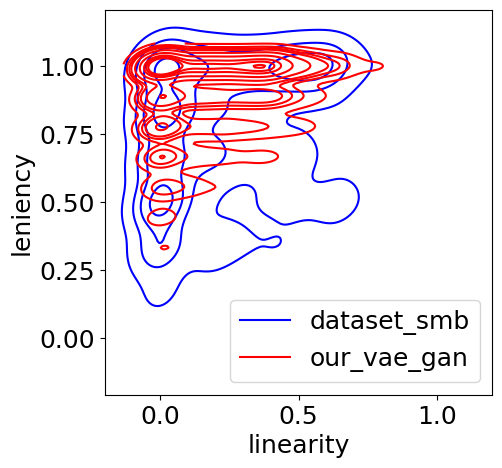

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


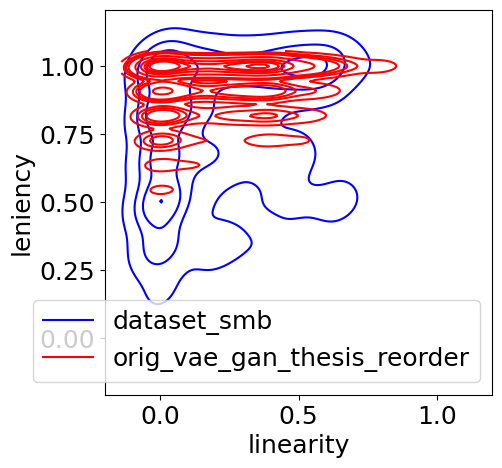

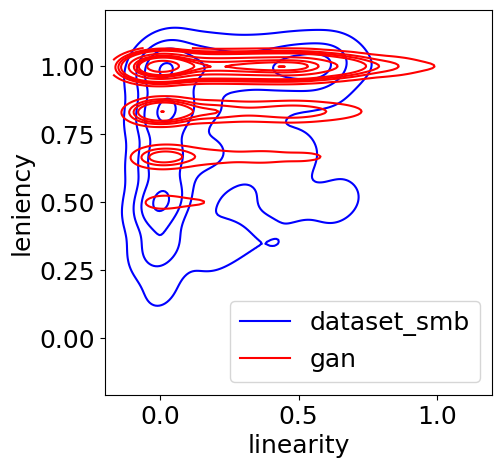

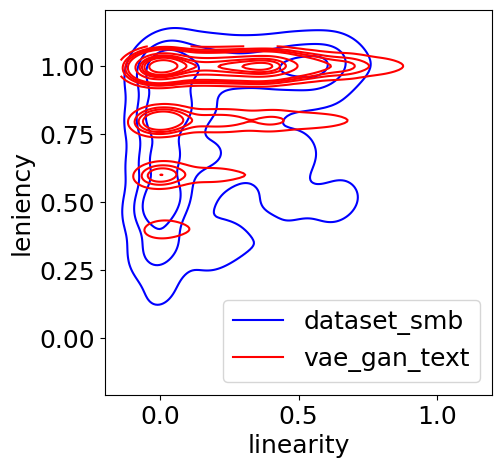

In [ ]:
file_1s = ["real_dataset_smb_large_stats.xlsx"] * 4
file_2s = ["our_vae_wgan_ks_large_stats.xlsx", "orig_vae_wgan_ks_thesis_reorder_stats.xlsx", "wgan_ks_large_stats.xlsx", "vae_wgan_ks_text_large_stats.xlsx"]
plot_kde_metrics(file_1s,
                 file_2s,
                 "linearity",
                 "leniency"
                 )

# **2 - Compare The 3 Models on the Kid Icarus Dataset**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1978 dataset_ki
3956 our_vae_gan
1978 dataset_ki
3956 original_vae_gan
1978 dataset_ki
3956 gan
1978 dataset_ki
3956 vae_gan_text


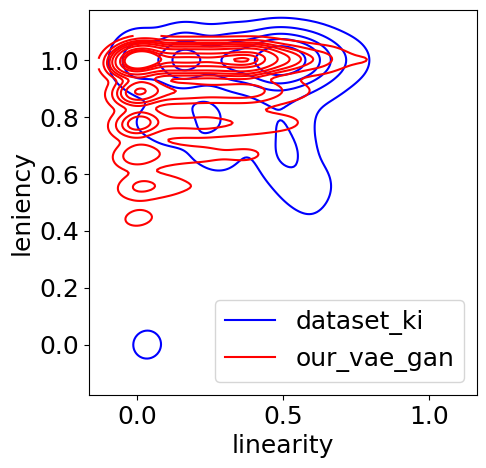

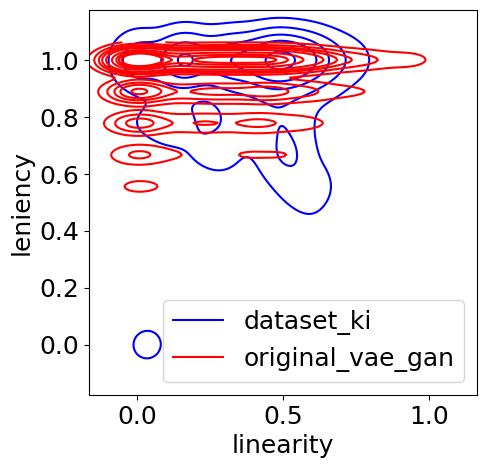

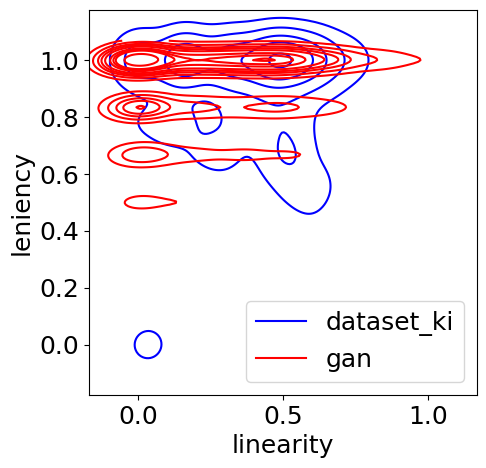

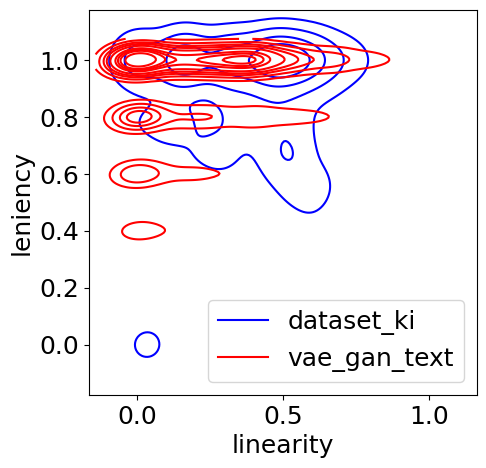

In [ ]:
file_1s = ["real_dataset_ki_large_stats.xlsx"] * 4
file_2s = ["our_vae_wgan_ks_large_stats.xlsx", "original_vae_wgan_stats.xlsx", "wgan_ks_large_stats.xlsx", "vae_wgan_ks_text_large_stats.xlsx"]
plot_kde_metrics(file_1s,
                 file_2s,
                 "linearity",
                 "leniency"
                 )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


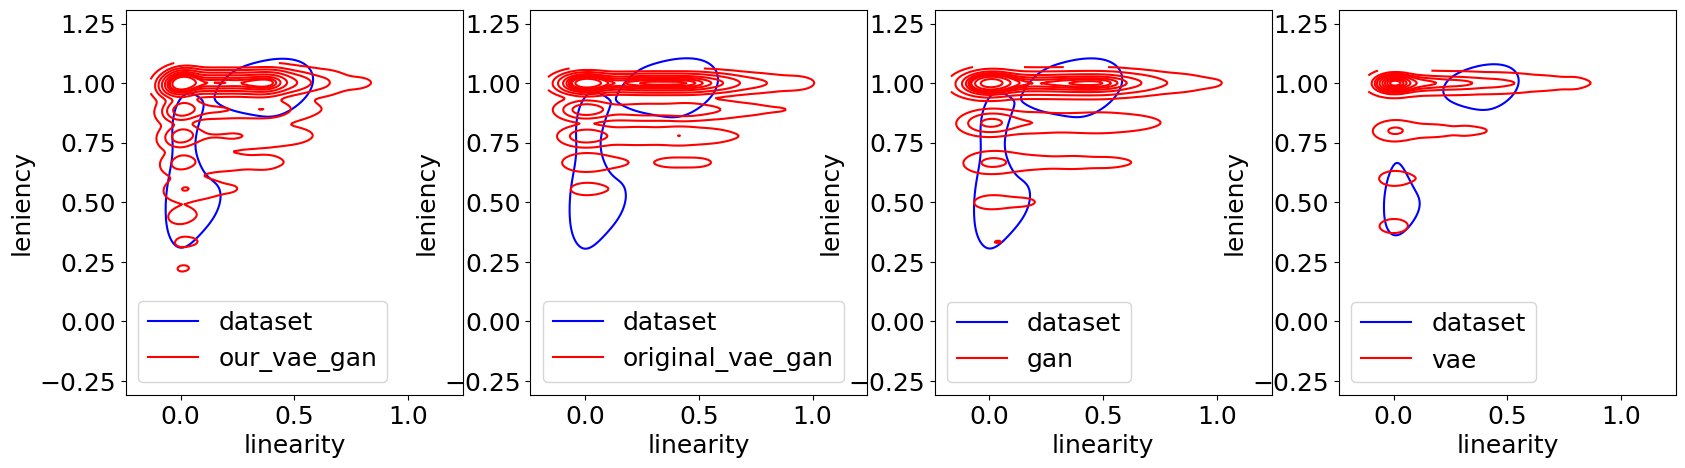

In [ ]:
file_1s = [ ["real_test_dataset_ki_stats.xlsx" , "real_test_dataset_smb_stats.xlsx"] * 4 ]
file_2s = ["our_vae_wgan_ks_large_stats.xlsx", "original_vae_wgan_stats.xlsx", "wgan_ks_large_stats.xlsx", "vae_ks_large_stats.xlsx"]
plot_kde_metrics_all_dataset(file_1s,
                 file_2s,
                 "linearity",
                 "leniency"
                 )

In [ ]:
%cd "../../../src"
from playability import *

/content/drive/MyDrive/joint_level_generation_translation/src


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

In [ ]:
import pickle
import random
import json
import pandas as pd
from alive_progress import alive_bar



def convert_to_list(list_of_numpy: list) -> "list[list[str]]":
    result = []
    for line in list_of_numpy:
        result.append(line.tolist())
    return result


def get_descriptions():
    platformerDescription = {}
    for filename in ["smb.json", "ki.json"]:
        with open(f"{filename}", "r") as data_file:
            platformerDescription[filename.replace(".json", "")] = json.load(data_file)
    return platformerDescription


def calc_playability_metric(filename, game, mode="entire"):
    platformerDescription = get_descriptions()
    num_success = 0
    with open(f"../double_check/generations/{init_seed}/{filename}.pkl", "rb") as fh:
        data = pickle.load(fh)
        to_write = []
        if mode != "entire":
            data = random.sample(data, 100)
        with alive_bar(len(data), force_tty=True) as bar:
            for frame in data:
                success = False
                frame = convert_to_list(frame)
                ret = findPathsFull(platformerDescription[game], frame, game)
                if ret:
                    to_write.append([ret])
                    num_success += 1
                else:
                  to_write.append([False])

                bar()

        df = pd.DataFrame(to_write, columns=["playability"])
        # df.to_excel(f"{filename}_stats.xlsx")
        return num_success/len(data)
        # print("----------------------------------------------------")
        # print(f"Percentage of playable frames of {filename}:", num_success/len(data))

In [ ]:
playability_results = []

In [ ]:
for f in file_names:
  for game in ["ki", "smb"]:
    score = calc_playability_metric(f, game=game, mode="entire")
    playability_results.append({"game": game, "dataset": f, "playability" : score})


|████████████████████████████████████████| 3956/3956 [100%] in 1:19.4 (49.79/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b59d8e20>


|████████████████████████████████████████| 3956/3956 [100%] in 14.6s (270.43/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5064f40>


|████████████████████████████████████████| 3956/3956 [100%] in 1:40.4 (39.35/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12af937d60>


|████████████████████████████████████████| 3956/3956 [100%] in 13.8s (287.55/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5453760>


|████████████████████████████████████████| 3956/3956 [100%] in 1:35.3 (41.48/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b4e3ad40>


|████████████████████████████████████████| 3956/3956 [100%] in 19.4s (204.52/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12af937580>


|████████████████████████████████████████| 3956/3956 [100%] in 1:12.1 (54.83/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5a2b640>


|████████████████████████████████████████| 3956/3956 [100%] in 14.5s (273.17/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b4e3bfa0>


|████████████████████████████████████████| 3956/3956 [100%] in 1:45.0 (37.69/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b4e3b9a0>


|████████████████████████████████████████| 3956/3956 [100%] in 14.0s (283.66/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12b5a29120>


|████████████████████████████████████████| 1978/1978 [100%] in 31.8s (62.10/s)  


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12aeb5b460>


|████████████████████████████████████████| 1978/1978 [100%] in 8.3s (237.78/s)  


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12aeb7e020>


|████████████████████████████████████████| 1978/1978 [100%] in 1:11.9 (27.52/s) 


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12aeb32440>


|████████████████████████████████████████| 1978/1978 [100%] in 7.6s (260.54/s)  


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e12aebaeb00>


In [ ]:
df = pd.DataFrame(playability_results)
result = df.to_html()
IPython.display.HTML(result)

,game,dataset,playability
0,ki,our_vae_wgan_ks_large,0.544237
1,smb,our_vae_wgan_ks_large,0.856926
2,ki,orig_vae_wgan_1234,0.607432
3,smb,orig_vae_wgan_1234,0.828615
4,ki,orig_vae_wgan_33662,0.608443
5,smb,orig_vae_wgan_33662,0.848332
6,ki,orig_vae_wgan_49782,0.557634
7,smb,orig_vae_wgan_49782,0.874115
8,ki,original_vae_wgan,0.597826
9,smb,original_vae_wgan,0.854651
